In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import mode


# pipelines
from sklearn.pipeline import Pipeline



# Customer Data

In this assignment we are going to examine some customer data gathering from my very famous internet company "the best one ever".  "The best one ever" is the best company ever that sells important things online.  In this investigation we want to find if there are any natural groups of customers in my dataset.  The first step is to just get the data in a format we can feed to our machine learning models. Once we do that, then our boss (some dude named Gilad), said he will teach us how to cluster the customers! But it turns out you need to have the _data_ formatted in some special way...? Maybe you can tell me about that!

# Tips

* It's a perfectly good idea to just open the CSV file up with excel, but maybe easier to just open it in jupyter lab. Lab has a very good CSV reader, which will allow you to "look" around very easily.

* When loading the dataset, you may need to pay special attention to where the index is and tell pandas where it is

In [3]:
# Read in the data found in "best_one_ever_database.csv" and take a look at the head and info.
data = pd.read_csv("best_one_ever_database.csv", index_col = 'id')

In [4]:
data.head()

,first_name,last_name,email,gender,ip_address,sales,zip_code,total_num_of_transactions,prob_of_rebuy,money_spent
id,,,,,,,,,,
1,Jarred,Hallsworth,jhallsworth0@biblegateway.com,Non-Binary,223.109.240.148,$606.16,85349,7,NaN,3310.505486
2,Wayne,Robez,wrobez1@t.co,Male,73.174.113.87,$147.22,85336,9,NaN,2188.852818
3,Casper,Hayles,chayles2@cdc.gov,Male,223.249.117.173,$801.97,85350,4,0.597445,2640.499644
4,Mandie,Szepe,mszepe3@lulu.com,Female,31.143.95.228,$336.77,85364,4,NaN,2872.580992
5,Noam,Cecely,ncecely4@elegantthemes.com,Male,63.71.174.230,$757.45,85369,8,0.127835,2728.008966


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1 to 2000
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   first_name                 2000 non-null   object 
 1   last_name                  2000 non-null   object 
 2   email                      2000 non-null   object 
 3   gender                     2000 non-null   object 
 4   ip_address                 2000 non-null   object 
 5   sales                      2000 non-null   object 
 6   zip_code                   2000 non-null   int64  
 7   total_num_of_transactions  2000 non-null   int64  
 8   prob_of_rebuy              1538 non-null   float64
 9   money_spent                1690 non-null   float64
dtypes: float64(2), int64(2), object(6)
memory usage: 171.9+ KB


# Cleaning The Data

Taking a look at the data you have to ask yourself the questions

1. 'Which columns are useful for me to keep?'
2. 'Are all the columns usable as features?

Then you may have to do some "work" to get the column to be usable. Let's look at one column together. The first column is titled "first_name" and it seems to be the first name of each customer. Is this a usable feature? Well... not exactly in string format. So I guess I could one hot encode them into binary vectors, but even then... do I want to cluster the customers based on their first name? You can imagine some situation where clustering by name might be relevant (for example trying to guess what generation someone belonged to?) but in this case it seems like it's more of a unique identifier so it may be best to simply remove it. If every value in a column is unique (there are no duplications of the value) then we shouldn't use it as a feature because it will have a 1-1 mapping with the target variable which is not something we ever want. We want our model to learn and generalize from the features, not memorize that the name "jane" bought 5 cans of soda.

Ok, that's the first column, we vote drop! Now you have to go through each and every column and ask yourself "do I keep it? if yes, what extra work might I have to do?" 

Let's walk through it
  
  1. first_name:  this is a unique identifier so we should remove it.
  2. last_name: see above
  3. email: this is unique to an extent.  BUT if we strip the name@ portion of the email and simply keep the domain name, it could possibly aid us. Perhaps certain kinds of customers use certain email services! Worth looking into
  4. Gender: this is certainly relevant, but it's categorical data. We will need to one-hot-encode it.
  5. ip_address: We can perhaps segment the ip's into fields and use them, there maybe overlaps or correlations among different fields. Or maybe you know more about IP addresses than I do and this is totally useless
  6. sales: we certainly need this column, but we need to convert it a floating point type: remove the '$' and convert the dtype of the column
  7. zip_code: I think we can just leave this as is.
  8. prob-of_rebuy: I think we can just leave this as is.
  9. Money_spent: seems fine to me!

In [6]:
# drop the name columns using pandas.drop()

X = data.drop(labels = ['first_name','last_name'], axis = 1)

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1 to 2000
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   email                      2000 non-null   object 
 1   gender                     2000 non-null   object 
 2   ip_address                 2000 non-null   object 
 3   sales                      2000 non-null   object 
 4   zip_code                   2000 non-null   int64  
 5   total_num_of_transactions  2000 non-null   int64  
 6   prob_of_rebuy              1538 non-null   float64
 7   money_spent                1690 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 140.6+ KB


### Transform string columns into useful features

1. email column
2. sales column (remove $ sign)

We will use the pandas `apply` function take a function that operates on a string and apply it to the entire column. I will do the first one, and you will do the next one.

In [8]:
def strip_dollar(x):
    return x[1:]

In [9]:
# apply the function to the column and assign it back to the column (it does not work inplace)
X.sales = X.sales.apply(strip_dollar)

# cast the column to a floating point type - this is very important, otherwise it will be
# an object type column that we cannot do arithmetic on the column
X.sales = X.sales.astype('float32')

In [10]:
X.head()

,email,gender,ip_address,sales,zip_code,total_num_of_transactions,prob_of_rebuy,money_spent
id,,,,,,,,
1,jhallsworth0@biblegateway.com,Non-Binary,223.109.240.148,606.159973,85349,7,NaN,3310.505486
2,wrobez1@t.co,Male,73.174.113.87,147.220001,85336,9,NaN,2188.852818
3,chayles2@cdc.gov,Male,223.249.117.173,801.969971,85350,4,0.597445,2640.499644
4,mszepe3@lulu.com,Female,31.143.95.228,336.769989,85364,4,NaN,2872.580992
5,ncecely4@elegantthemes.com,Male,63.71.174.230,757.450012,85369,8,0.127835,2728.008966


### Your Turn

Now you need to
1. write a function to strip the name portion of the email
2. Apply it to the column


In [11]:
# define functions to apply to the dataframe
def strip_emails(x):
    at = x.find('@')
    return x[at+1:]

test_email = 'thisismymail@gmail.com'
print(strip_emails(test_email))

gmail.com


In [12]:
# apply the function to the column and assign it back to the column (it does not work inplace)
X.email = X.email.apply(strip_emails)
X.head()

,email,gender,ip_address,sales,zip_code,total_num_of_transactions,prob_of_rebuy,money_spent
id,,,,,,,,
1,biblegateway.com,Non-Binary,223.109.240.148,606.159973,85349,7,NaN,3310.505486
2,t.co,Male,73.174.113.87,147.220001,85336,9,NaN,2188.852818
3,cdc.gov,Male,223.249.117.173,801.969971,85350,4,0.597445,2640.499644
4,lulu.com,Female,31.143.95.228,336.769989,85364,4,NaN,2872.580992
5,elegantthemes.com,Male,63.71.174.230,757.450012,85369,8,0.127835,2728.008966


# Is the email column going to be worth it?
Let's take a look at this email column and decide if it could help us or not.


In [13]:
# how many unique domains are there?
counts = X.email.value_counts()

In [14]:
print(counts.values)

[10 10 10 10 10 10  9  9  9  9  9  9  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3

No, it doesn't seem like this column will be very helpful as it's quite spread out. There are 490 unique values and no one value has a majority, so let's just leave it to the side for now. We can always come back to it later.

In [15]:
# we make sure to copy it over and save it for later.
emails = X.email.copy()
X.drop('email', axis=1, inplace = True)

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1 to 2000
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gender                     2000 non-null   object 
 1   ip_address                 2000 non-null   object 
 2   sales                      2000 non-null   float32
 3   zip_code                   2000 non-null   int64  
 4   total_num_of_transactions  2000 non-null   int64  
 5   prob_of_rebuy              1538 non-null   float64
 6   money_spent                1690 non-null   float64
dtypes: float32(1), float64(2), int64(2), object(2)
memory usage: 117.2+ KB


## Splitting the IP Address
We now need to split up the IP address, we will use Pandas's built in str method for this.

In [17]:
X[['first_ip','second_ip','third_ip','fourth_ip']] = X.ip_address.str.split(pat=".", expand=True)

In [18]:
# now we cast the columns as floats
X[['first_ip','second_ip','third_ip','fourth_ip']] = X[['first_ip','second_ip','third_ip','fourth_ip']].astype('float32')
# we also drop the original column
X.drop('ip_address', axis=1, inplace=True)

In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1 to 2000
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gender                     2000 non-null   object 
 1   sales                      2000 non-null   float32
 2   zip_code                   2000 non-null   int64  
 3   total_num_of_transactions  2000 non-null   int64  
 4   prob_of_rebuy              1538 non-null   float64
 5   money_spent                1690 non-null   float64
 6   first_ip                   2000 non-null   float32
 7   second_ip                  2000 non-null   float32
 8   third_ip                   2000 non-null   float32
 9   fourth_ip                  2000 non-null   float32
dtypes: float32(5), float64(2), int64(2), object(1)
memory usage: 132.8+ KB


# One Hot Encoding

Ok we are almost done, we just have to convert the gender column into something integer that we can use. We will use one-hot-encoding since gender is a categorical variable.

Pandas has a `get_dummies()` function that will be very useful.


In [20]:
X.gender.value_counts()

Male          775
Female        725
Non-Binary    500
Name: gender, dtype: int64

In [21]:
dumbdumbs = pd.get_dummies(X['gender'])
X= pd.concat((X,dumbdumbs), axis = 1)
X.drop(['gender'], axis = 1, inplace=True)
X.head()

,sales,zip_code,total_num_of_transactions,prob_of_rebuy,money_spent,first_ip,second_ip,third_ip,fourth_ip,Female,Male,Non-Binary
id,,,,,,,,,,,,
1,606.159973,85349,7,NaN,3310.505486,223.0,109.0,240.0,148.0,0,0,1
2,147.220001,85336,9,NaN,2188.852818,73.0,174.0,113.0,87.0,0,1,0
3,801.969971,85350,4,0.597445,2640.499644,223.0,249.0,117.0,173.0,0,1,0
4,336.769989,85364,4,NaN,2872.580992,31.0,143.0,95.0,228.0,1,0,0
5,757.450012,85369,8,0.127835,2728.008966,63.0,71.0,174.0,230.0,0,1,0


In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1 to 2000
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sales                      2000 non-null   float32
 1   zip_code                   2000 non-null   int64  
 2   total_num_of_transactions  2000 non-null   int64  
 3   prob_of_rebuy              1538 non-null   float64
 4   money_spent                1690 non-null   float64
 5   first_ip                   2000 non-null   float32
 6   second_ip                  2000 non-null   float32
 7   third_ip                   2000 non-null   float32
 8   fourth_ip                  2000 non-null   float32
 9   Female                     2000 non-null   uint8  
 10  Male                       2000 non-null   uint8  
 11  Non-Binary                 2000 non-null   uint8  
dtypes: float32(5), float64(2), int64(2), uint8(3)
memory usage: 123.0 KB


# Data Preprocessing Stage 2 - Missing values
Ok, we are done with stage 1 (we have converted everything into numeric features and dropped all the unneccessary things.

However we do have missing values. Which two columns have missing values?
How many values are missing?
What should we do about those missing values?

You can either impute (fill in) the missing values, or drop the rows which contain them. The choice is up to you!
Either way, you should practice both methods. This way you can practice coding both solutions.

Note:
The `DataFrame.fillna()` method essentially assumes that you are using timeseries data. We are not, so I wouldn't use this. In order to impute simple values, you can use numpy easily, but... I'm lazy and would probably use the scikit-learn implementation.

https://scikit-learn.org/stable/modules/impute.html


In [23]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

In [24]:
X_ = imp.fit_transform(X)

In [25]:
X= pd.DataFrame(X_, columns=X.columns)

In [26]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sales                      2000 non-null   float64
 1   zip_code                   2000 non-null   float64
 2   total_num_of_transactions  2000 non-null   float64
 3   prob_of_rebuy              2000 non-null   float64
 4   money_spent                2000 non-null   float64
 5   first_ip                   2000 non-null   float64
 6   second_ip                  2000 non-null   float64
 7   third_ip                   2000 non-null   float64
 8   fourth_ip                  2000 non-null   float64
 9   Female                     2000 non-null   float64
 10  Male                       2000 non-null   float64
 11  Non-Binary                 2000 non-null   float64
dtypes: float64(12)
memory usage: 187.6 KB


In [27]:
X.head()

,sales,zip_code,total_num_of_transactions,prob_of_rebuy,money_spent,first_ip,second_ip,third_ip,fourth_ip,Female,Male,Non-Binary
0,606.159973,85349.0,7.0,0.510104,3310.505486,223.0,109.0,240.0,148.0,0.0,0.0,1.0
1,147.220001,85336.0,9.0,0.510104,2188.852818,73.0,174.0,113.0,87.0,0.0,1.0,0.0
2,801.969971,85350.0,4.0,0.597445,2640.499644,223.0,249.0,117.0,173.0,0.0,1.0,0.0
3,336.769989,85364.0,4.0,0.510104,2872.580992,31.0,143.0,95.0,228.0,1.0,0.0,0.0
4,757.450012,85369.0,8.0,0.127835,2728.008966,63.0,71.0,174.0,230.0,0.0,1.0,0.0


# Clustering

Ok, now we have our customer data all ready to go. We have done all the hard work of preprocessing. Let's feed this data into our algorithms!

We'll try two different clustering algorithms. K-means and DB-scan.


Our goal is to cluster the data and learn what kinds of customers we have, are they related to one another at all? In order to do this we should try some clustering

## K-means

Let's just make some clusters and evaluate it with their silhouette score. A reminder about the silhouette score

>The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

From : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score

Your Job:
Run a k-means loop on clusters 2-n (you decide how many you want to try!) and see which # of clusters is best.

You should scale the data first since we are hunting for clusters we definitely want the dimensions to be on the same scale (remember that distance means everything here!).

#### Note:
In an effort to slowly remove your training wheels, I have not important everything you need to accomplish your tasks here.


In [28]:
# clustering
from sklearn.cluster import DBSCAN, KMeans

# clustering metrics
from sklearn.metrics import silhouette_score

In [29]:
# scale your data with a scaler of your choice
ss = StandardScaler()
x_scaled = ss.fit_transform(X)

In [30]:
# random guess for k
kmeans = KMeans(n_clusters = 10)
kmeans.fit(x_scaled)

KMeans(n_clusters=10)

In [31]:
labels = kmeans.predict(x_scaled)
print(silhouette_score(x_scaled, labels))

0.08789486274186283


In [32]:
for i in range(2,20):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(x_scaled)
    labels = kmeans.predict(x_scaled)
    print(f"The number of clusters is {i} and the Silhouette score is {silhouette_score(x_scaled, labels)}")

The number of clusters is 2 and the Silhouette score is 0.1329368135348219
The number of clusters is 3 and the Silhouette score is 0.1913558686436536
The number of clusters is 4 and the Silhouette score is 0.13958141973307905
The number of clusters is 5 and the Silhouette score is 0.11901756297433533
The number of clusters is 6 and the Silhouette score is 0.10822010533036769
The number of clusters is 7 and the Silhouette score is 0.09611797460481375
The number of clusters is 8 and the Silhouette score is 0.09697043119983671
The number of clusters is 9 and the Silhouette score is 0.091136866145011
The number of clusters is 10 and the Silhouette score is 0.0888706009032568
The number of clusters is 11 and the Silhouette score is 0.08795612091244351
The number of clusters is 12 and the Silhouette score is 0.08827853964853188
The number of clusters is 13 and the Silhouette score is 0.08435964184799388
The number of clusters is 14 and the Silhouette score is 0.09096435528511315
The number o

### Cluster Discussion

Ok, so we found the best number of clusters according to the silhouette score.  So what? I mean to say, what do we do with that? We know that according the silhouette score this is the best, but... even if that's correct, _now what_? How do we use these clusters to help us run our business?
How can we learn what these clusters represent?

I can think of one thing to check

1. Look at the feature values of the cluster centroids.

Recall that every cluster in kmeans has a centroid. That centroid is the very _center_ of the cluster, so we can look at the feature values of the centroids and see what they tell us. In theory the centroids represent the cluster (generally). 

We can look at the cluster centroids right now.  Let's examine then with a barplot.

I'm going to give you some code help here.

In [33]:
# fit a kmeans cluster with desired number of components
kmeans = KMeans(3).fit(x_scaled)

In [34]:
X.shape

(2000, 12)

In [35]:
# look for the centers of your clusters.  
# Hint: your kmeans object has an attribute you'd want to use
centers = kmeans.cluster_centers_
print(kmeans.cluster_centers_.shape)
print(kmeans.cluster_centers_)


(3, 12)
[[-2.08022379e-02  5.91840088e-02 -1.24893583e-02  1.14703470e-03
   6.78961682e-03 -1.92466136e-02 -6.16755144e-03  5.52603075e-02
   2.07500298e-02  1.32612997e+00 -7.95394909e-01 -5.77350269e-01]
 [ 4.13769256e-02 -2.57378564e-02 -1.01718633e-03 -1.86939575e-02
  -3.50383462e-02 -1.25077317e-02  1.53321053e-02 -3.08946489e-02
  -1.15358160e-02 -7.54073903e-01  1.25723711e+00 -5.77350269e-01]
 [-3.39709897e-02 -4.59231353e-02  1.96862083e-02  2.73124339e-02
   4.44644922e-02  4.72945738e-02 -1.48218137e-02 -3.22407400e-02
  -1.22070285e-02 -7.54073903e-01 -7.95394909e-01  1.73205081e+00]]


In [36]:
# my gift to you
def plot_centroids(centers):
    pd.DataFrame(centers, columns = X.columns).plot(kind = 'bar', figsize = (12,6))
    plt.legend(loc='best', bbox_to_anchor=(0.8, 0.1, 0.5, 0.5)); # bbox is (x,y, width, height)


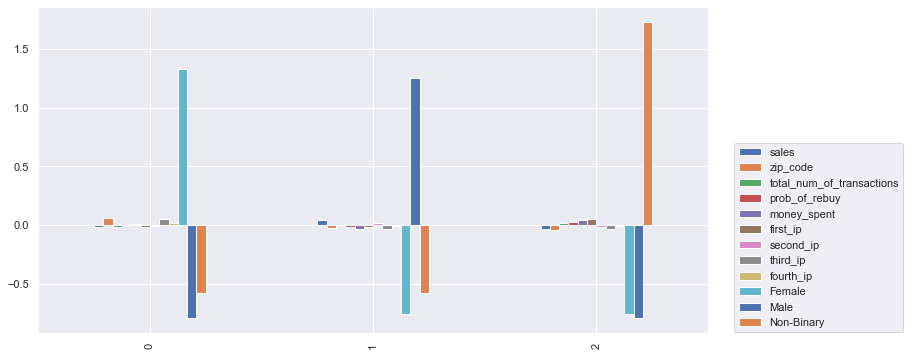

In [37]:
plot_centroids(centers)

# Examine your centroids

What does your graph tell you?
What features are the most important and contributing towards the clusters?

Extra-Credit: Rerun your clustering algorithm with a _different_ scaling method and re-examine your centroid features. Do they change? Why? What does it mean?

# DB-Scan

Let's now try DB-scan. Remember we have three parameters we need to set
1. `eps` the radius of our circle that we will search in
2. `min_samples` the minimum number of samples we need to find within our radius to call it a cluster
3. `metric` our distance metric.  Defaults to Euclidean (L2-norm).

So, we get to fiddle with 3 parameters, but we don't have to worry about "how many" clusters to look for, db-scan will decide for us.

Go ahead and run it!
What is the best eps / min_samples ?
What gets you the best silhouette score?

In order to answer these questions we will need to figure out a few things

1. run dbscan (that's pretty easy)
2. how many clusters did it find?
3. how do we get the labels (predictions) from the dbscan object?

In [38]:
# run dbscan 
# pick an eps -- how might we do this? what range are your features in?
# Your eps should be relevant to the feature space you exist in
# pick min_samples

dbscan = DBSCAN(eps=3.0, min_samples=5).fit(x_scaled)


#### ok, now you fit a dbscan. 
1. how do we figure out how many clusters it found?
DBscan has 3 main attributes, 1

>**core_sample_indices_ndarray of shape (n_core_samples,)**
Indices of core samples.

>**components_ndarray of shape (n_core_samples, n_features)**
Copy of each core sample found by training.

>**labels_ndarray of shape (n_samples)**
Cluster labels for each point in the dataset given to fit(). Noisy samples are given the label -1.

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

Go ahead and look at those attributes. Print them out. Which one will help us figure out how many clusters DBscan found?

Also pay attention to changing `eps`, if `eps` is too small what happens? Too large?

In [39]:
dbscan.labels_

array([0, 1, 1, ..., 1, 0, 2], dtype=int64)

In [40]:
dbscan.labels_.shape

(2000,)

In [41]:
dbscan.components_.shape

(1989, 12)

In [42]:
dbscan.core_sample_indices_

array([   0,    1,    2, ..., 1997, 1998, 1999], dtype=int64)

In [43]:
dbscan.core_sample_indices_.shape

(1989,)

## Calculate the Silhouette Score

In order to perform the silhouette score we need the labels (that's pretty easy they are given to us), however we should _exclude_ the -1's because they represent points that are _not_ in a cluster. So they are basically discarded. We should probably collect those somewhere and else and see how large that number is. But it should not be part of the silhouette core.

So
1. seperate out the points which have the label `-1`

Then after we have done that, we can calcluate the silhouette score easily. 
#### NOTE
DBscan in scikit-learn is implemented with the notion of "core samples".  From the [documentation:](https://scikit-learn.org/stable/modules/clustering.html#dbscan)
>More formally, we define a core sample as being a sample in the dataset such that there exist min_samples other samples within a distance of eps, which are defined as neighbors of the core sample. This tells us that the core sample is in a dense area of the vector space. A cluster is a set of core samples that can be built by recursively taking a core sample, finding all of its neighbors that are core samples, finding all of their neighbors that are core samples, and so on. **A cluster also has a set of non-core samples, which are samples that are neighbors of a core sample in the cluster but are not themselves core samples.** Intuitively, these samples are on the fringes of a cluster.

This means that the attributes `components` and `core_sample_indices` will only return core samples, for us to get all the points _within_ the cluster we will have to rely on the labels

### Number of clusters?
But what about the # of clusters? How many did we find and how many in each cluster? We need to examine the labels again, but this time count the unique ones and also count how many of each unique we have.

### Goal
Run our little line of code, which gives both the score and # of clusters.

`print(f"The number of clusters is {num_clusters} and the Silhouette score is {silhouette_score(x_scaled, dbscan.labels_)}")`


Oh! we also should probably add
`print(f"The number of discarded points was {}")`


In [44]:
uniques, counts = np.unique(dbscan.labels_, return_counts=True)
print(uniques)
print(counts)

[-1  0  1  2]
[  1 500 775 724]


In [45]:
dbscan.core_sample_indices_.shape

(1989,)

In [46]:
dbscan.labels_!=-1

array([ True,  True,  True, ...,  True,  True,  True])

In [47]:
x_scaled.shape

(2000, 12)

In [48]:
## remove the -1's from the labels.
## you also will need to remove the corresponding x_scaled samples so you can compute the silhouette score.
# you can use numpy boolean indexing masks for this.

labels = dbscan.labels_[dbscan.labels_!=-1]
x_points = x_scaled[dbscan.labels_!=-1]

In [49]:
labels.shape

(1999,)

In [50]:
x_points.shape

(1999, 12)

In [51]:
## ok if you have the labels and x's without -1's you can actually computer the Silhouette score now
silhouette_score(x_points, labels)

0.19139771794639499

In [52]:
## how many clusters are there though?
## you need to figure out how many unique labels there are, and also it would be nice to know
## how many points are in each cluster

In [53]:
#  https://www.kite.com/python/answers/how-to-count-frequency-of-unique-values-in-a-numpy-array-in-python

uniques, counts = np.unique(labels, return_counts=True)

In [54]:
print(uniques)

[0 1 2]


In [55]:
print(np.asarray((uniques,counts)).T)

[[  0 500]
 [  1 775]
 [  2 724]]


In [56]:
num_clusters = len(np.unique(labels))
print(f"The number of clusters is {num_clusters} and the Silhouette score is {silhouette_score(x_points, labels)}")

The number of clusters is 3 and the Silhouette score is 0.19139771794639499


### How does it compare?

Did your DBscan find similar clusters to k-means? Same number of clusters? More ? Less? What about the silhouette score? Better or worse?


### Next we'd like to look at the centroids

Actually, DBscan doesn't have centroids naturally the same way k-means does. But we can compute it ourselves.
We would need to isolate the points of each group, and then just take the mean column wise, that would represent the centroid of each cluster.  You can do this with a numpy mask



In [57]:
labels.shape

(1999,)

In [58]:
centers = []
for label in uniques:
    centers.append(x_points[labels==label].mean(axis=0))

dbcenters = np.array(centers)

In [59]:
dbcenters

array([[-3.39709897e-02, -4.59231353e-02,  1.96862083e-02,
         2.73124339e-02,  4.44644922e-02,  4.72945738e-02,
        -1.48218137e-02, -3.22407400e-02, -1.22070285e-02,
        -7.54073903e-01, -7.95394909e-01,  1.73205081e+00],
       [ 4.13769256e-02, -2.57378564e-02, -1.01718633e-03,
        -1.86939575e-02, -3.50383462e-02, -1.25077317e-02,
         1.53321053e-02, -3.08946489e-02, -1.15358160e-02,
        -7.54073903e-01,  1.25723711e+00, -5.77350269e-01],
       [-2.31225013e-02,  5.82374677e-02, -1.37552243e-02,
         1.14861900e-03,  1.95485869e-03, -1.78551261e-02,
        -4.43231739e-03,  5.31704837e-02,  2.16615952e-02,
         1.32612997e+00, -7.95394909e-01, -5.77350269e-01]])

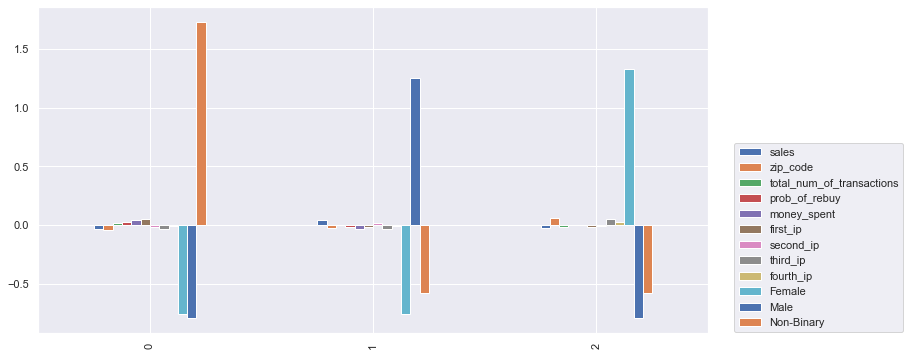

In [60]:
plot_centroids(dbcenters)

# How do your centroids compare?

Did you find similar clusters? Dissimilar?


# PCA
Ok now we want to do PCA.
We'll do three things

1. Plot the cumulative sum of PCA's explained variance ratio, this will help us identify how much information we are losing when we downsample with PCA
2. Plot a scatter plot of the PCA data in 2 dimensions
3. Look at the PCA loadings, this will tell us which features are contributing to the new PCA dimensions.

In [61]:
from sklearn.decomposition import PCA

In [67]:
# make a PCA object.
# fit your PCA object on the scaled data
# look at the PCA shape , is it what you expected?
pca = PCA().fit(x_scaled)

In [68]:
def display_scree_plot(pca):
    '''Display a scree plot for the pca'''
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    
    scree = pca.explained_variance_ratio_*100
    ax.bar(np.arange(len(scree))+1, scree)
    ax.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    ax.set_xlabel("Principal components")
    ax.set_ylabel("Percentage explained variance")
    ax.set_title("Scree plot")
    return ax

<AxesSubplot:title={'center':'Scree plot'}, xlabel='Principal components', ylabel='Percentage explained variance'>

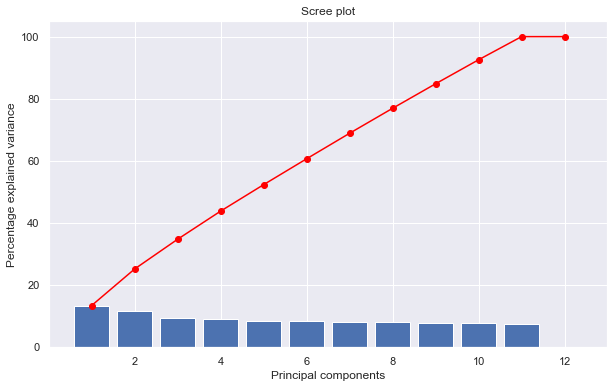

In [69]:
# plot your scree plot
display_scree_plot(pca)

# The 'elbow' method of cumsum plots

With the elbow method of a cumulative sum plot (cumsum), we want to find the point where we see a drop-off in gains.  Often with PCA we can get "the most bang for our buck" with a few components that account for most of explained variance.  Looking at the plot above, what points seems like good choices? (this particular case may not have a great "elbow", so you might want to just pick an arbitrary cutoff).


# Your answer here:

In this case there does not appear to be a very clear 'elbow'. After the first two bars, each component seems to contribute about the same amount of variance. At this point, one may instead look to remove features entirely (such as the four ip numbers). But assuming that we're sticking with PCA, maybe selecting 8 components will be sensible. This will give about 80% of the variance, while still removing 3 dimensions.

# PCA plots

Regardless of the best number of PCA components to use, we want to plot our data in 2d, in order to do this, we will just select the first two components.  How much variance do we keep with the first two dimensions? How will it inform your opinion of our 2d scatter plot?

In [70]:
# transform the scaled data with PCA
x_sca_pca = pca.transform(x_scaled)

In [77]:
pca_var = pca.explained_variance_ratio_
print("The amount of variance in the first two dimensions is", 100*(pca_var[0]+pca_var[1]), "%")

The amount of variance in the first two dimensions is 25.202868621003795 %


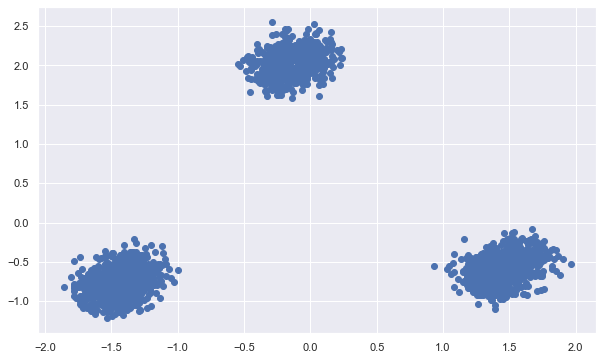

In [85]:
# perform a scatter plot of the PCA data
# you'll want to use the first and second PCA components to plot.
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x_sca_pca[:,0], x_sca_pca[:,1])

Ok! So the graph looks obviously quite promising. This also seems to line up with what our clusters told us.  Let's see if the cluster assignments fit the PCA plot correctly or not.

In [86]:
# get labels from K-means
# note we should predict on the same data we fit K-means with. So if we fit with data "x_scaled" we need to be sure to predict on that data.
# it would be a mistake to make predictions on the PCA transformed data now, because we did not fit the kmeans object on the PCA data!
labels = kmeans.predict(x_scaled)

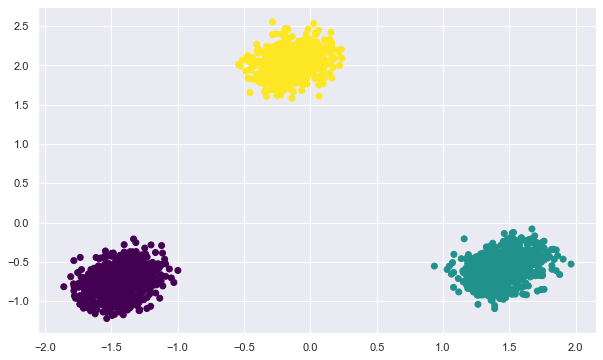

In [87]:
fig, ax = plt.subplots(figsize=(10,6));

# plot your datapoints again, this time with colors for labels.  I gave you some helper code below
ax.scatter(x_sca_pca[:,0],x_sca_pca[:,1], c=labels, cmap='viridis');

#### What do you think of the results?

The labels from KMeans perfectly line-up with the clusters seen above. Our KMeans algorithm clustered by gender. This customer information has been captured by the first PCA dimension. We have one gender at (approx) -1.5, the next at 0.0, and then 1.5. There will be a little contribution from other features too (else all our dots would line up vertically at their respective x-axis labels). This makes perfect sense. To encode information about the customer's gender, we only need one dimension (not 3). The issue that arises however is about relating unrelated concepts. For example, if Male is at -1, Female at 0, and Non-Binary at +1, it doesn't make sense to say that Male is 'closer' to Female than to Non-Binary. This could mess up our notions of distance. The above plot rectifies this situation in two dimensions though: all three clusters are approximately equidistant (forming an equilateral triangle).

## PCA Components examined

Ok so we have plotted our clusters in 2D and it seems to be lining up with our previous analysis.  The next step is to examine the "loadings" which represent how much of the original features are contributing to our new PCA functions.
PCA is a mathematical operation (SVD - singular value decomposition) a transformation from the original feature space into a new feature space. That transformation can be represented as a matrix - we call it the _covariance_ matrix and it's used to project the features from the original space into the PCA space. By examining the coefficients (loadings) in the covariance matrix we can get an idea what the new PCA features are composed of. 


In [88]:
def plot_pca_comps(pca_item, num_dims, data):
    
    variance_ratios = pca_item.explained_variance_ratio_
    components = pd.DataFrame(pca_item.components_[:num_dims], columns = data.columns)
    
    fig, ax = plt.subplots(figsize = (14,8))
    
    components.plot(ax=ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    dims = [f'Dimension {i}' for i in range(num_dims)]
    ax.set_xticklabels(labels =dims,rotation=0)
    
    # Display the explained variance ratios
    for i, ev in enumerate(pca_item.explained_variance_ratio_[:num_dims]):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, f"Explained Variance\n {np.round(ev,4)}")

    ax.legend(loc='best', bbox_to_anchor=(0.75, 0.1, 0.5, 0.5)) # bbox is (x,y, width, height)
    


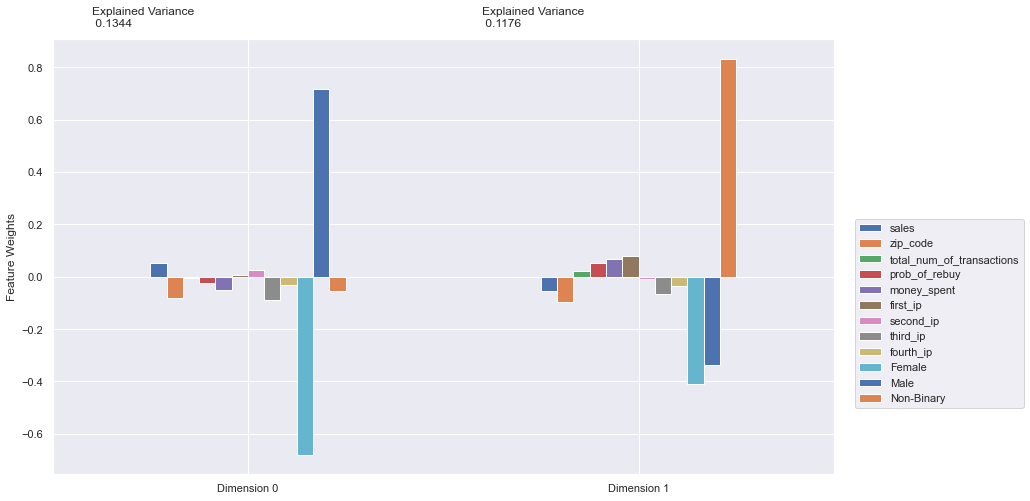

In [91]:
# pass PCA, # of dimensions to plot, X the data )
plot_pca_comps(pca, 2, X)

# What do the loadings tell us?

The components of PCA each are created by combining all the existing features. We see the existing features in the legend and the PCA bar-plot tells us the coefficients of the covariance matrix found by PCA. When you are reading the bar plot, you should look for the lines with largest magnitude. The sign (positive vs negative) does not matter, because it can be reversed (it's random each time PCA runs, it can be either direction). The features which are contributing to that PCA dimension are the features with the largest magnitude. If they are in opposite directions it means the features have an anti-correlation to one another. If they are in the same direction, then the features are correlated and PCA is finding that.

What can you tell from looking at PC1 and PC2 (the first two dimensions?).  Note that we were able to cluster very efficiently with just these two PC dimensions, which of these original features are defining these clusters?

What relationship do you see between the centroids of your kmeans clusters and the PCA components?

#### Your answer here


This agrees with the previous analysis under the scatter plot. The 3 gender dimensions overwhelmingly contribute to PCA1 and PCA2. Non-Binary is not explicitly encoded in PCA1 (though the lack of Male (+) or Female (-) i.e. 0 would indicate a Non-Binary customer). But PCA2 is orthogonal to PCA1 so this previously 'suppressed' statistic comes out strongly and is anti-correlated with Male & Female. As predicted earlier, the other features do contribute in minor ways. But this small contribution is likely just noise and not meaningful in the same way that the 3 gender dimensions are.

This is a very similar situation to the KMeans centroids: gender is the most important statistic in determining these clusters, with the other features merely noise.

## feel free to look at more PCA loadings, extend the graph to all 6 components.

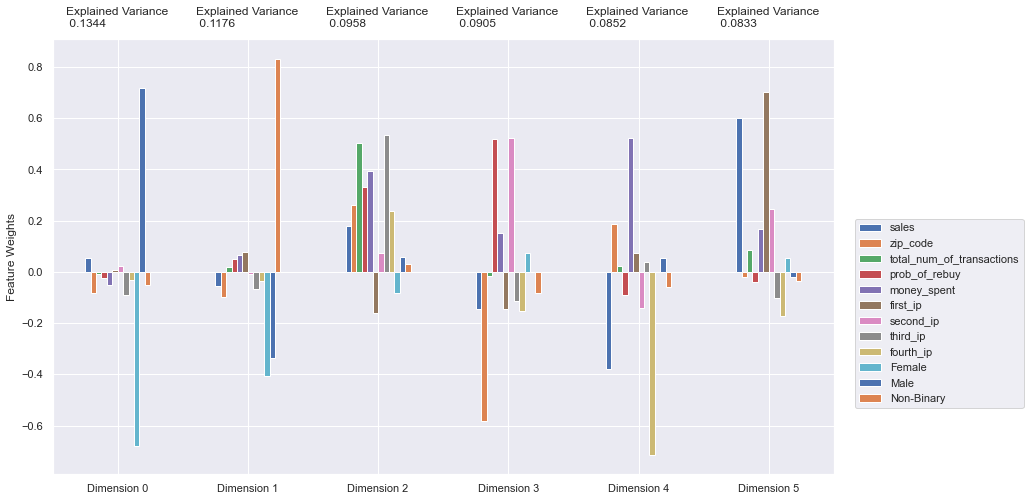

In [92]:
plot_pca_comps(pca, 6, X)

## Clustering on PCA transformed data
Ok, our final idea!

 * Cluster our data upon the PCA tranformed data and see if we get similar results
 * To do this we need to first:
  1. scale the data
  2. fit_transform with pca
  3. cluster on the PCA data


In [93]:
## do the work here
scaler = StandardScaler()
new_x = scaler.fit_transform(X)
pca = PCA(n_components=2)
pca_x = pca.fit_transform(new_x)
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(pca_x)

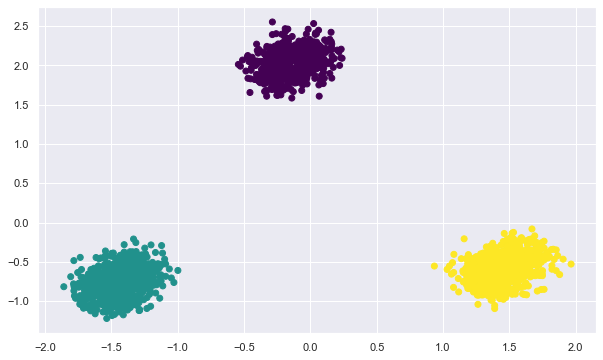

In [94]:

# plot your results here
fig, ax = plt.subplots(figsize=(10,6));
ax.scatter(pca_x[:,0],pca_x[:,1], c=labels, cmap='viridis');

In [95]:
# In order to look at the centroids we need to inverse them back into the scaled space.
centers =  pca.inverse_transform(kmeans.cluster_centers_)

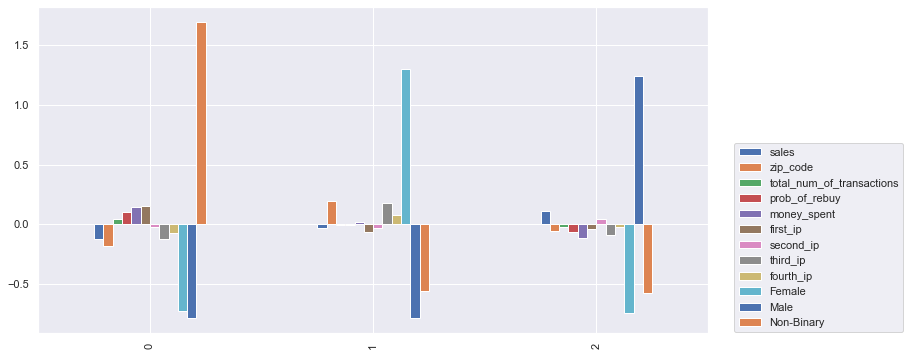

In [96]:
plot_centroids(centers)

### Can we learn clusters on the PCA data effectively? At least in this case

Your answer here:

In this case: Yes. In general: No (I think).

In this case there didn't seem to be any real difference between doing KMeans first then PCA, versus doing PCA then KMeans on that new data. It was intuitively clear to believe that this would work, looking at the previously drawn 2D plots.

This may not be the case in general, however. The aim of PCA is to find a subspace of maximal variance - with spread out data. This could mess with our distance metrics, and make clusters harder to find if the important dimensions have been cut (or have minimal contribution in the loadings). Though this might be unlikely; for a cluster to exist we need at least one dimension with two dense regions separated by some empty-ish region. Such a dimension should then contain a fair amount of variance. But if the clusters are very far apart, then PCA might cut that dimension for having too low variance. This line of reasoning would suggest that very far apart and clearly defined clusters would be less detectable on PCA transformed data, while remaining fairly obvious on the original data.

To figure this out it might be helpful to look at the mathematics, or to see if one can find specific examples where the PCA process removes cluster information. My guess is that it shouldn't be too hard to find such an example. e.g. one could be in the plane (2D) and have data that looks like two vertical (dotted) lines, with lots of equally spaced out dots. PCA1 would probably be the vertical line (y-axis). This would delete the obvious clustering of the data into the two original lines.